## Import library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pickle
import cv2
from tqdm import tqdm
from pathlib import Path
import imageio as iio
import imgaug.augmenters as ia
import imgaug
import numpy as np
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import defaultdict

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}

data_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/datadir'

class_names = sorted(os.listdir(data_dir))

In [5]:
print(class_names)

['calloused_hands_baseball_field', 'calloused_hands_car', 'calloused_hands_diner', 'calloused_hands_josh_s_house', 'calloused_hands_rabbi_s_house', 'calloused_hands_school', 'calloused_hands_synagogue', 'chained_for_life_garden', 'chained_for_life_hospital', 'chained_for_life_hotel', 'liberty_kid_carnival', 'liberty_kid_house1', 'liberty_kid_house2', 'liberty_kid_prison', 'liberty_kid_statue_of_liberty', 'like_me_diner', 'like_me_gas_station', 'like_me_motel', 'little_rock_caravan', 'little_rock_fun_place', 'little_rock_gallery', 'little_rock_house1', 'little_rock_house2', 'little_rock_motel', 'little_rock_shop', 'losing_ground_home1', 'losing_ground_home2', 'losing_ground_neighbourhood', 'losing_ground_rental_house', 'losing_ground_rooftop', 'losing_ground_university-workplace']


# ResNet18

# Testing all images in test set (500):

In [9]:
# CPU
loaded_model_500 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-resnet_500_2.pth', map_location=device)

#GPU
#loaded_model = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-resnet_500_2.pth')
loaded_model_500.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_model_500(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_resnet18_500.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 2 predicted/39 frames
losing_ground_rental_house: 37 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: losing_ground_rental_house (37 predictions)

---------------------Predictions in a shot---------------------
losing_ground_rental_house: 9 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: losing_ground_rental_house (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 2 predicted/12 frames
little_rock_caravan: 1 predicted/12 frames
losing_ground_rental_house: 9 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: losing_ground_rental_house (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_field: 12 predicted/12 frames
=

# Testing all images in test set (200):

In [ ]:
loaded_model_200 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-resnet_200_1.pth', map_location=device)

#GPU
#loaded_model = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-resnet_500_2.pth')
loaded_model_200.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_model_200(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_resnet18_200.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 2 predicted/39 frames
losing_ground_rental_house: 37 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: losing_ground_rental_house (37 predictions)

---------------------Predictions in a shot---------------------
losing_ground_rental_house: 9 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: losing_ground_rental_house (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 2 predicted/12 frames
losing_ground_rental_house: 9 predicted/12 frames
little_rock_caravan: 1 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: losing_ground_rental_house (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_field: 12 predicted/12 frames
=

# Testing all images in test set (100):

In [ ]:
loaded_model_100 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-resnet_100_2.pth', map_location=device)

#GPU
#loaded_model = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-resnet_500_2.pth')
loaded_model_100.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_model_100(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_resnet18_100.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 9 predicted/39 frames
losing_ground_rental_house: 30 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: losing_ground_rental_house (30 predictions)

---------------------Predictions in a shot---------------------
little_rock_caravan: 3 predicted/9 frames
losing_ground_rental_house: 6 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: losing_ground_rental_house (6 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 9 predicted/12 frames
liberty_kid_house1: 1 predicted/12 frames
losing_ground_rental_house: 2 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: calloused_hands_car (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseba

#Đánh giá trên tập test (500):

In [7]:
def read_file(file_path):
    data = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = map(str.strip, line.split(': '))
            data[key] = value
    return data
def eval(predictions_path, labels_path):
    predictions_data = read_file(predictions_path)
    labels_data = read_file(labels_path)

    total = len(labels_data)
    correct_predictions = sum(1 for key, value in labels_data.items() if key in predictions_data and predictions_data[key] == value)

    accuracy = (correct_predictions / total) * 100
    print('correct:',correct_predictions,'/',total,'shots')
    return accuracy

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_resnet18_500.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 101 / 176 shots
accuracy: 57.39%


#Đánh giá trên tập test (200):

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_resnet18_200.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 98 / 176 shots
accuracy: 55.68%


#đánh giá trên tập test (100):

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_resnet18_100.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 98 / 176 shots
accuracy: 55.68%


#Test in one shot:

In [12]:
shot_folder = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset/Calloused_Hands-37-shot_5'
num = len(os.listdir(shot_folder))
n = 4
m = -(-num // n)
i = 1

shot_name = os.path.basename(shot_folder)

predictions_count = defaultdict(int)

for image_name in os.listdir(shot_folder):
    image_test = os.path.join(shot_folder, image_name)
    image = Image.open(image_test)

    transform = data_transforms['valid']
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)  # Assuming you have defined the 'device' variable

    with torch.no_grad():
        outputs = loaded_model_500(input_image)

    _, preds = torch.max(outputs, 1)
    true_class = image_name[:-4]

    # Increment the count for the predicted class
    predictions_count[class_names[preds.item()]] += 1

    plt.figure(figsize=(20, 20))
    plt.subplot(m, n, i)
    i += 1
    plt.axis('off')
    plt.imshow(image)
    plt.title(f"Frame: {true_class}\nPredicted: {class_names[preds.item()]}", fontsize=8)
    plt.show()
    #print('\n')

for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num} frames")
# Tìm shot_label có count lớn nhất
max_count_label = max(predictions_count, key=predictions_count.get)
print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

Output hidden; open in https://colab.research.google.com to view.

# MobileNet:

# Testing all images in test set (500):

In [14]:
# CPU
loaded_mobilenet_500 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-mobilenet_500_1.pth', map_location=device)
loaded_mobilenet_500.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_mobilenet_500(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_mobilenet_500.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 36 predicted/39 frames
liberty_kid_house1: 3 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: calloused_hands_car (36 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 9 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: calloused_hands_car (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 5 predicted/12 frames
liberty_kid_house1: 7 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: liberty_kid_house1 (7 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_field: 12 predicted/12 frames
=> Calloused_Hands-2-shot_1 is: calloused_hands_baseball_field (12 predictions)

--------

# Testing all images in test set (200):

In [ ]:
# CPU
loaded_mobilenet_200 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-mobilenet_200_2.pth', map_location=device)
loaded_mobilenet_200.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_mobilenet_200(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_mobilenet_200.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 39 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: calloused_hands_car (39 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 9 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: calloused_hands_car (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 11 predicted/12 frames
liberty_kid_house1: 1 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: calloused_hands_car (11 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_field: 12 predicted/12 frames
=> Calloused_Hands-2-shot_1 is: calloused_hands_baseball_field (12 predictions)

---------------------Predictions in a shot-----

# Testing all images in test set (100):

In [ ]:
# CPU
loaded_mobilenet_100 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-mobilenet_100_1.pth', map_location=device)
loaded_mobilenet_100.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_mobilenet_100(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_mobilenet_100.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 39 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: calloused_hands_car (39 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 9 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: calloused_hands_car (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 12 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: calloused_hands_car (12 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_field: 12 predicted/12 frames
=> Calloused_Hands-2-shot_1 is: calloused_hands_baseball_field (12 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_

#Đánh giá trên tập test (500):

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_mobilenet_500.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 107 / 176 shots
accuracy: 60.80%


#Đánh giá trên tập test (200):

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_mobilenet_200.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 103 / 176 shots
accuracy: 58.52%


#đánh giá trên tập test (100):

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_mobilenet_100.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 104 / 176 shots
accuracy: 59.09%


#Test in one shot:

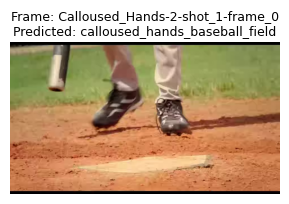

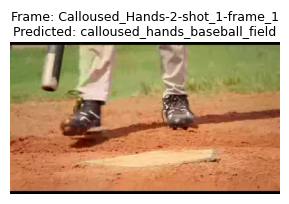

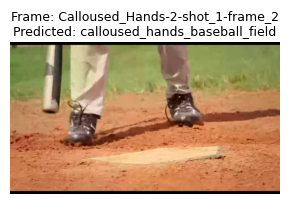

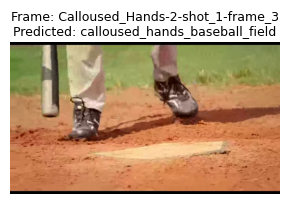

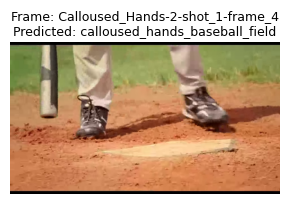

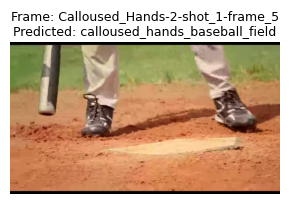

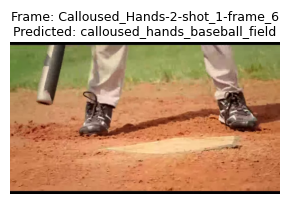

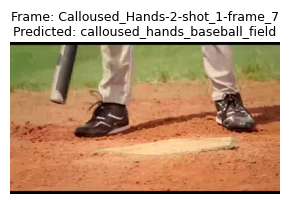

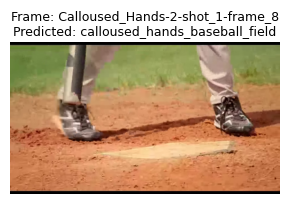

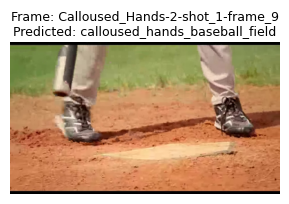

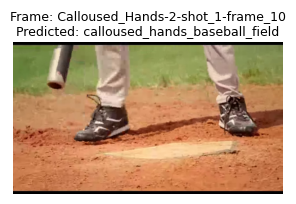

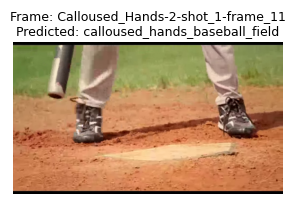

calloused_hands_baseball_field: 12 predicted/12 frames
=> Calloused_Hands-2-shot_1 is: calloused_hands_baseball_field (12 predictions)



In [17]:
shot_folder = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset/Calloused_Hands-2-shot_1'
num = len(os.listdir(shot_folder))
n = 4
m = -(-num // n)
i = 1

shot_name = os.path.basename(shot_folder)

predictions_count = defaultdict(int)

for image_name in os.listdir(shot_folder):
    image_test = os.path.join(shot_folder, image_name)
    image = Image.open(image_test)

    transform = data_transforms['valid']
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)  # Assuming you have defined the 'device' variable

    with torch.no_grad():
        outputs = loaded_mobilenet_500(input_image)

    _, preds = torch.max(outputs, 1)
    true_class = image_name[:-4]

    # Increment the count for the predicted class
    predictions_count[class_names[preds.item()]] += 1

    plt.figure(figsize=(16, 16))
    plt.subplot(m, n, i)
    i += 1
    plt.axis('off')
    plt.imshow(image)
    plt.title(f"Frame: {true_class}\nPredicted: {class_names[preds.item()]}", fontsize=9)
    plt.show()
    #print('\n')

for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num} frames")
# Tìm shot_label có count lớn nhất
max_count_label = max(predictions_count, key=predictions_count.get)
print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

# VGG16:

# Testing all images in test set (500):

In [18]:
# CPU
loaded_vgg16_500 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-vgg16_500_1.pth', map_location=device)
loaded_vgg16_500.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_vgg16_500(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_vgg16_500.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 39 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: calloused_hands_car (39 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 9 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: calloused_hands_car (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 12 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: calloused_hands_car (12 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_field: 12 predicted/12 frames
=> Calloused_Hands-2-shot_1 is: calloused_hands_baseball_field (12 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_

# Testing all images in test set (200):

In [ ]:
loaded_vgg16_200 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-vgg16_200_1.pth', map_location=device)
loaded_vgg16_200.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_vgg16_200(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_vgg16_200.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 39 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: calloused_hands_car (39 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 9 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: calloused_hands_car (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 12 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: calloused_hands_car (12 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_field: 12 predicted/12 frames
=> Calloused_Hands-2-shot_1 is: calloused_hands_baseball_field (12 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_

# Testing all images in test set (100):

In [ ]:
loaded_vgg16_100 = torch.load('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/checkpoints_train/best_model_aug-vgg16_100_1.pth', map_location=device)
loaded_vgg16_100.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
test_shots_dir = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset'
count = 0
count_true = 0

num_shot = len(os.listdir(test_shots_dir))

for shot_name in os.listdir(test_shots_dir):
    shot_path = os.path.join(test_shots_dir, shot_name)
    count_true_class = 0
    count_class = 0
    num_fr = len(os.listdir(shot_path))

    predictions_count = defaultdict(int)

    for image_name in os.listdir(shot_path):
        image_path = os.path.join(shot_path, image_name)
        image = Image.open(image_path)
        transform = data_transforms['valid']  # Sử dụng chuyển đổi cho tập kiểm thử
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        input_image = input_image.to(device)

        with torch.no_grad():
            outputs = loaded_vgg16_100(input_image)

        _, preds = torch.max(outputs, 1)
        true_class = image_name[:-4]

        predictions_count[class_names[preds.item()]] += 1

        #print(f'Frame: {true_class}\n-> Predicted: {class_names[preds.item()]}')

    print("---------------------Predictions in a shot---------------------")
    for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num_fr} frames")
    # Tìm shot_label có count lớn nhất
    max_count_label = max(predictions_count, key=predictions_count.get)
    print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

    with open('/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_vgg16_100.txt', 'a') as file:
            file.write(f"{shot_name}: {max_count_label}\n")

---------------------Predictions in a shot---------------------
calloused_hands_car: 14 predicted/14 frames
=> Calloused_Hands-1-shot_4 is: calloused_hands_car (14 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 39 predicted/39 frames
=> Calloused_Hands-1-shot_5 is: calloused_hands_car (39 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 9 predicted/9 frames
=> Calloused_Hands-1-shot_10 is: calloused_hands_car (9 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_car: 12 predicted/12 frames
=> Calloused_Hands-1-shot_21 is: calloused_hands_car (12 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_field: 12 predicted/12 frames
=> Calloused_Hands-2-shot_1 is: calloused_hands_baseball_field (12 predictions)

---------------------Predictions in a shot---------------------
calloused_hands_baseball_

#Đánh giá trên tập test (500):

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_vgg16_500.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 99 / 176 shots
accuracy: 56.25%


#Đánh giá trên tập test (200):

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_vgg16_200.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 97 / 176 shots
accuracy: 55.11%


#đánh giá trên tập test (100):

In [ ]:
labels_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/label_testset.txt"
predictions_path = "/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/label_shots_test/predictions_vgg16_100.txt"

accuracy = eval(predictions_path, labels_path)
print(f"accuracy: {accuracy:.2f}%")

correct: 96 / 176 shots
accuracy: 54.55%


#Test in one shot:

In [22]:
shot_folder = '/content/drive/MyDrive/Xu ly anh /Group_Thanh_Ha/test_shots_dataset/little_rock-37-shot_1'
num = len(os.listdir(shot_folder))
n = 4
m = -(-num // n)
i = 1

shot_name = os.path.basename(shot_folder)

predictions_count = defaultdict(int)

for image_name in os.listdir(shot_folder):
    image_test = os.path.join(shot_folder, image_name)
    image = Image.open(image_test)

    transform = data_transforms['valid']
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)  # Assuming you have defined the 'device' variable

    with torch.no_grad():
        outputs = loaded_vgg16_500(input_image)

    _, preds = torch.max(outputs, 1)
    true_class = image_name[:-4]

    # Increment the count for the predicted class
    predictions_count[class_names[preds.item()]] += 1

    plt.figure(figsize=(22, 22))
    plt.subplot(m, n, i)
    i += 1
    plt.axis('off')
    plt.imshow(image)
    plt.title(f"Frame: {true_class}\nPredicted: {class_names[preds.item()]}", fontsize=9)
    plt.show()
    #print('\n')

for shot_label, count in predictions_count.items():
        print(f"{shot_label}: {count} predicted/{num} frames")
# Tìm shot_label có count lớn nhất
max_count_label = max(predictions_count, key=predictions_count.get)
print(f"=> {shot_name} is: {max_count_label} ({predictions_count[max_count_label]} predictions)\n")

Output hidden; open in https://colab.research.google.com to view.